<a href="https://colab.research.google.com/github/horaciobaptista/Scikit-Learn/blob/main/mod_04_sklearn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#%% 01. importar modulos
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
!pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
#%% 02. importar folha de excel
filepath = 'winequality.xls'

df = pd.read_excel(filepath, sheet_name = 0)

In [17]:
#%% 03. gerar relatorio para escolha de paramateros - mudar working directory
import pandas_profiling # atencao: pode entrar em conflito com o seaborn
profile = pandas_profiling.ProfileReport(df, title='Relatório dos Dados')
profile.to_file("relatorio.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
#%% 04. renomear colunas
df.rename(columns={'type':'tipo'}, inplace=True)
df.rename(columns={'quality':'qualidade'}, inplace=True)

In [19]:
#%% 05. selecionar por criterio e converter target para binario
red   = df.loc[df['tipo'].isin(['red'])]
white = df.loc[df['tipo'].isin(['white'])]

white['vintage'] = (white['qualidade'] >= 7).astype(int)
white['vintage'].sum()


1060

<Axes: >

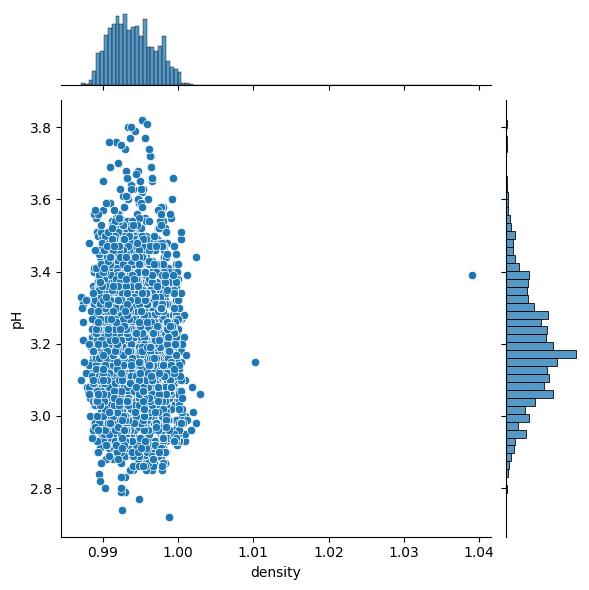

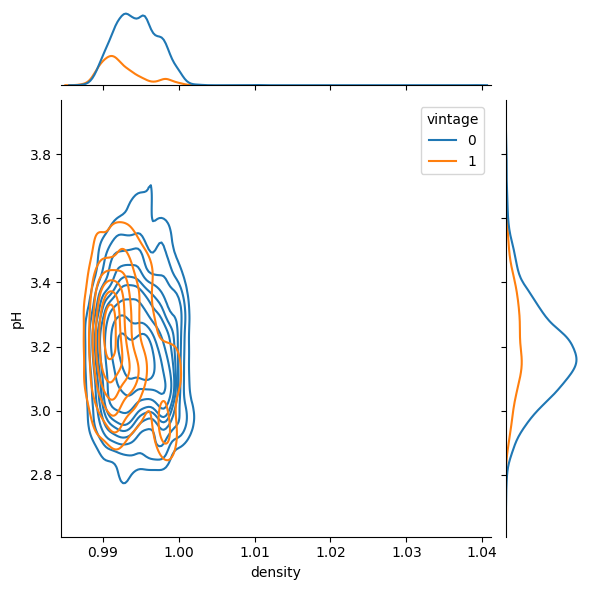

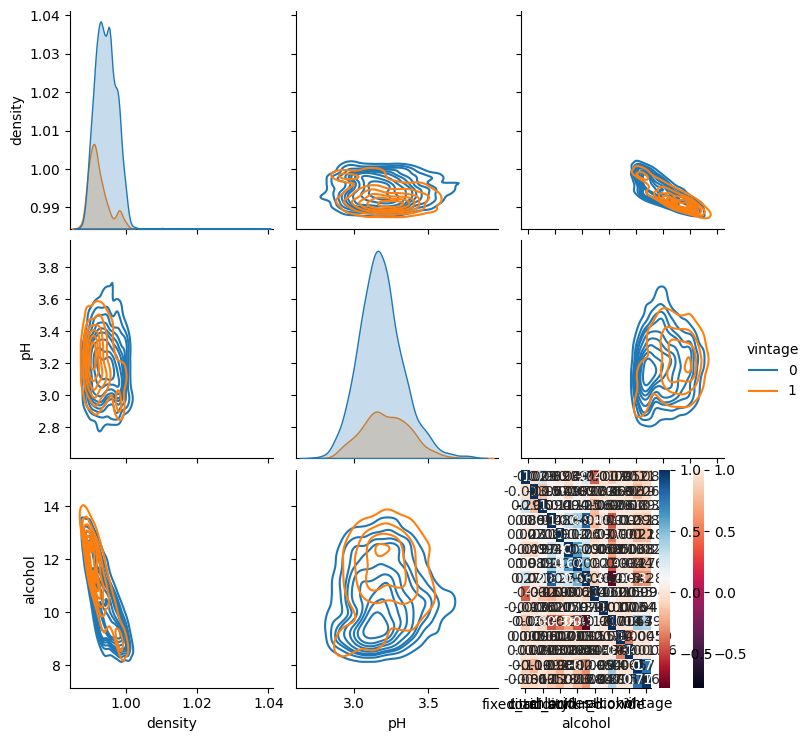

In [20]:


#%% 07. visualizacoes seaborn
import seaborn as sns

# seaborn jointplot { “scatter” | “kde” | “hist” | “hex” | “reg” | “resid” }
sns.jointplot(x='density', y='pH', data=white, kind="scatter")
sns.jointplot(x='density', y='pH', data=white, hue='vintage', kind="kde")

# seaborn pairplot
vars = ['density', 'pH', 'alcohol']
sns.pairplot(white, vars=vars, hue='vintage', kind='kde')

# seaborn heatmap (correlacao)
white.corr()
sns.heatmap(white.corr())
sns.heatmap(white.corr(), annot=True, cmap='RdBu')



In [21]:


#%% 08. metodologias para selecao de features
X = white.iloc[:,[1,2,3,4,5,6,7,8,9,10,11]] # selecionar por indice
y = white['qualidade'] # selecionar por nome

# (A) Variance Threshold
# -----------------------------------
X.var()
# seleciona features que cumpre o criterio
from sklearn.feature_selection import VarianceThreshold
SEL = VarianceThreshold(threshold=(1))

SEL.fit_transform(X)


# (B) Recursive Feature Elimination (RFE)
# -----------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

LR = LinearRegression()
RFE = RFE(estimator=LR, n_features_to_select=4, step=1)

RFE.fit(X, y)
RFE.ranking_

# (C) Select From Model
# -----------------------------------
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel

DTR = DecisionTreeRegressor().fit(X, y)
MODEL = SelectFromModel(DTR, prefit=True, threshold='median')
X_transformed = MODEL.transform(X) # output: FFMC, DC, temp, RH 



In [22]:

#%% 09. criar dataset de treino e teste
# X = X.iloc[:,[1,4,7]] # selecionar features para treinar o modelo

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



In [23]:

#%% 10. TREINAR MODELOS DE REGRESSAO ###  .fit, .score, .predict. (mesma API da classificacao)
#---------------------------------------
# (1) Linear Regression
from sklearn.linear_model import LinearRegression # regressao linear, ajuste da reta Y = mX + b
LR = LinearRegression().fit(X_train, y_train)
round(LR.score(X_test, y_test), 4)
LR.intercept_
LR.coef_ #quanto maior os coeficientes, mais impacto no modelo

#---------------------------------------
# (2) Decision Tree
from sklearn.tree import DecisionTreeRegressor # tendencia para o overfit
DTR = DecisionTreeRegressor(random_state=0).fit(X_train, y_train) # random_state tentativa/erro
round(DTR.score(X_test, y_test), 4)

for col, val in sorted(zip(X_train.columns, DTR.feature_importances_),
                       key=lambda x: x[1], reverse=True)[:11]:
    print(f"{col:10}{val:10.3f}")

#---------------------------------------
# (3) Random Forest
from sklearn.ensemble import RandomForestRegressor # generaliza melhor que as DTR
RFR = RandomForestRegressor(random_state=4).fit(X_train, y_train) # random_state tentativa/erro
round(RFR.score(X_test, y_test), 4)

for col, val in sorted(zip(X_train.columns, RFR.feature_importances_),
                       key=lambda x: x[1], reverse=True)[:11]:
    print(f"{col:10}{val:10.3f}")



alcohol        0.246
volatile_acidity     0.132
free_sulfur_dioxide     0.105
pH             0.075
sulphates      0.072
residual_sugar     0.069
chlorides      0.065
total_sulfur_dioxide     0.064
fixed_acidity     0.063
density        0.059
citric_acid     0.050
alcohol        0.251
volatile_acidity     0.128
free_sulfur_dioxide     0.109
pH             0.074
residual_sugar     0.071
chlorides      0.066
total_sulfur_dioxide     0.066
sulphates      0.062
density        0.059
fixed_acidity     0.058
citric_acid     0.057


In [24]:

#%% 11. METRICAS PARA AVALIACAO DE MODELOS
from sklearn import metrics

# metricas usadas
metrics = {
    'R2'   : metrics.r2_score,
    'MAE'  : metrics.mean_absolute_error,
    'RMSE' : metrics.mean_squared_error}

models = {
    'LR' : LR,
    'DTR': DTR,
    'RFR': RFR}

for i in metrics:
    print(f'\n{i}\n-----')
    for j in models:
        met = metrics[i]
        mod = models[j]
        
        y_test_pred = mod.predict(X_test)
        test_score  = met(y_test, y_test_pred)
        print(f'{j} {i}: {test_score:.4f}')




R2
-----
LR R2: 0.2513
DTR R2: 0.0877
RFR R2: 0.4538

MAE
-----
LR MAE: 0.6297
DTR MAE: 0.5327
RFR MAE: 0.4948

RMSE
-----
LR RMSE: 0.6598
DTR RMSE: 0.8041
RFR RMSE: 0.4814


In [25]:

#%% 12. PRODUZIR NOVAS ESTIMATIVAS DE CADA MODELO ####
# -----------------------------------------------
Xsel = df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11]] # selecionar por indice
Xsel.dropna(inplace=True) # limpar NaN caso existam

Xpred = Xsel.copy()

Xpred['LR']  = LR.predict(Xsel)
Xpred['DTR'] = DTR.predict(Xsel)
Xpred['RFR'] = RFR.predict(Xsel)

Xpred[['qualidade', 'X', 'Y']] = df[['qualidade', 'X', 'Y']]
Xpred.to_csv('mlearnexport.csv')

